In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
df = pd.read_csv("../input/blocks.csv")

In [3]:
df.head()

,Level,latBlock,lngBlock,month,day,hour,quarter,count
0,0,0,17,4,14,16,0,2
1,0,0,17,4,21,16,2,1
2,0,0,17,5,11,11,0,2
3,0,0,17,5,11,12,0,11
4,0,0,17,5,11,12,1,11


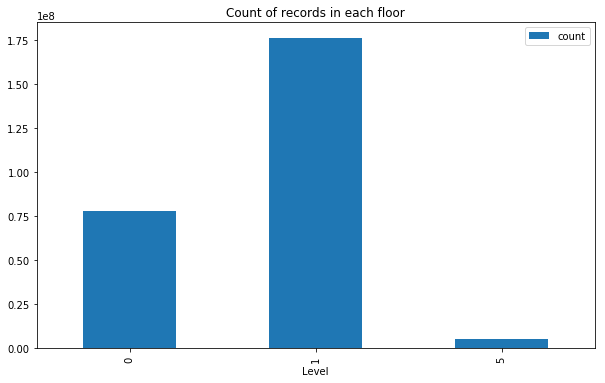

In [4]:
df.groupby("Level").agg({"count":"sum"}).plot(kind="bar",figsize=(10,6),title='Count of records in each floor')

In [5]:
%%time
mapper = dict()

for row in df.iterrows():
    x=row[1]
    key = (x['Level'], x['month'], x['day'], x['hour'], x['quarter'])
    if key[0]==5:
        val = mapper.get(key, np.zeros((15,15)))
    else:
        val = mapper.get(key, np.zeros((50,50)))
    val[x['lngBlock'],x['latBlock']]=x['count']
    mapper[key]=val

CPU times: user 10min 33s, sys: 2.52 s, total: 10min 35s
Wall time: 10min 32s


In [8]:
mapper[(5, 4, 26,9, 2)]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., 82.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,  0.,  0.,
         0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 16.,  0.,
         0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,
         0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  2.,  0.,  0.,  0.,  7.,
         0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       

In [6]:
def plotF(**kwargs):
    """
    plot in one day: {'day':(Level,month,day,0,0), 'blockPos':(lng,lat)}
    plot in one clock: {'hour':(Level,0,0,hour,quater), 'blockPos':(lng,lat)}
    """
    if "day" in kwargs:
        vector = []
        for key in mapper:
            if key[:3] == kwargs['day'][:3]:
                vector.append((key[3:], mapper[key][kwargs['blockPos']]))
        vector = map(lambda x: (x[0][0]*4+x[0][1], x[1]), sorted(vector, key=lambda x:x[0]))
    elif 'hour' in kwargs:
        vector = []
        for key in mapper:
            if key[0] == kwargs['day'][0] and key[3:]==kwargs['day'][3:]:
                vector.append((key[1:3], mapper[key][kwargs['blockPos']]))
        vector = map(lambda x: x[1], sorted(vector, key=lambda x:x[0]))
    else:
        print("False")
        return
    
    vector=np.array(list(vector))
    plt.figure(figsize=(10,6))
    plt.plot(vector[:,0],vector[:,1])
    #plt.show()

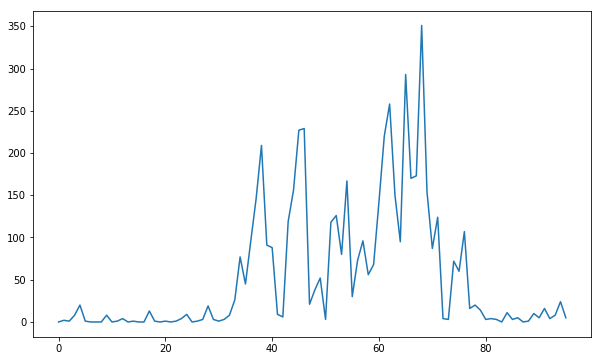

In [7]:
plotF(day = (0, 5, 26, 12, 0),blockPos=(25,26))

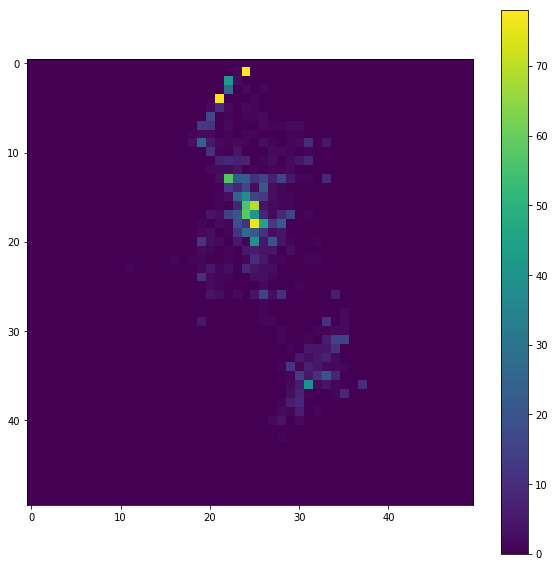

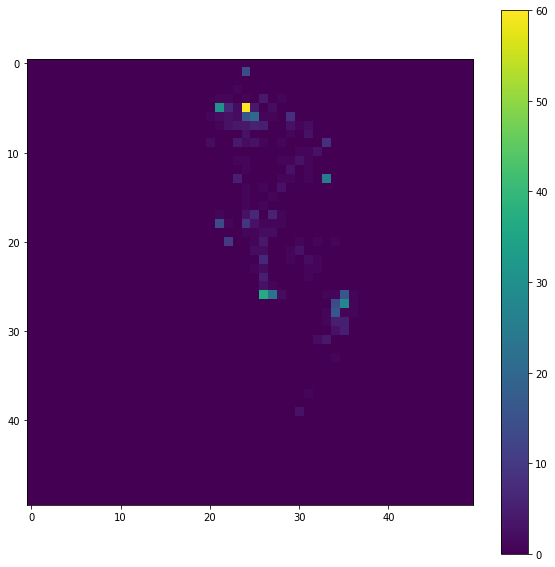

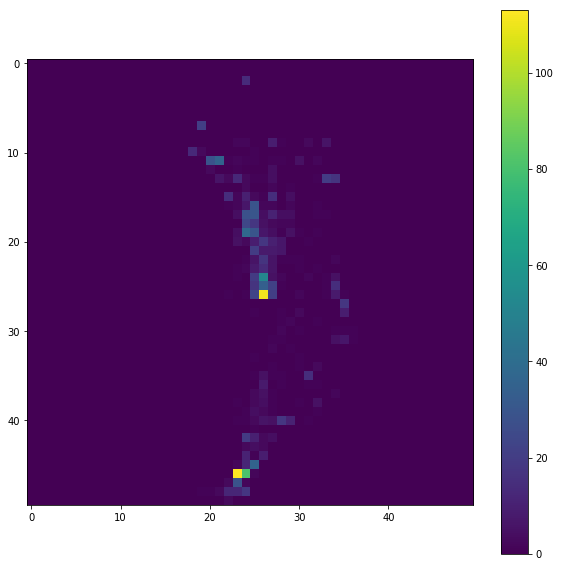

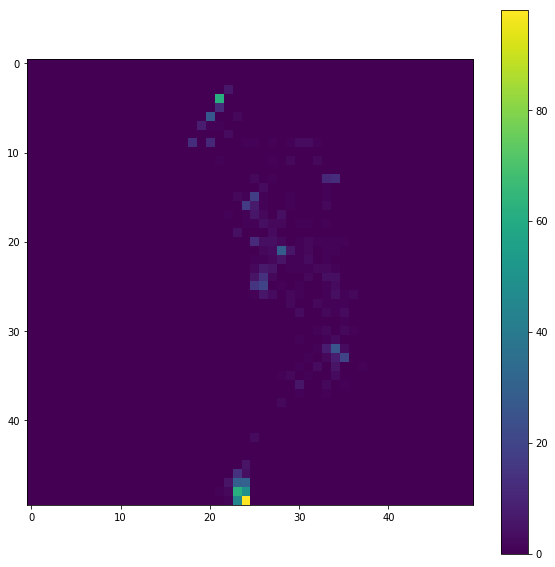

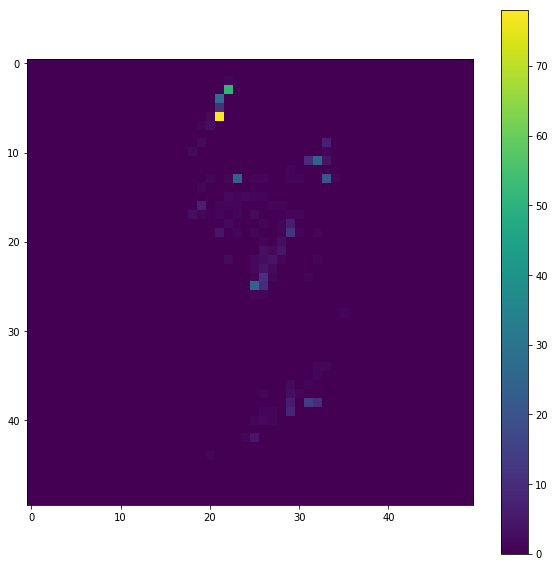

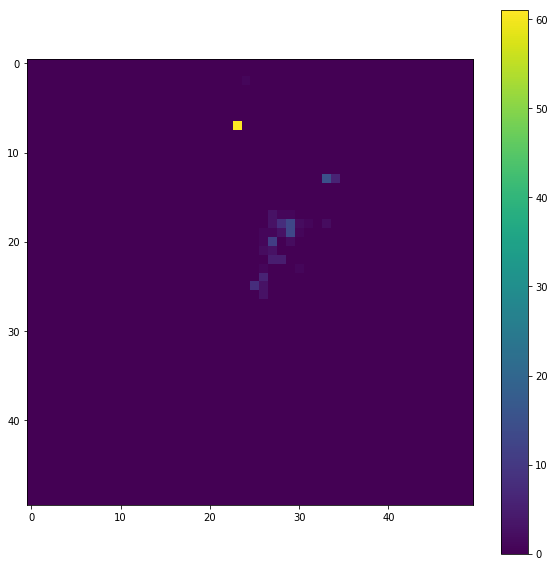

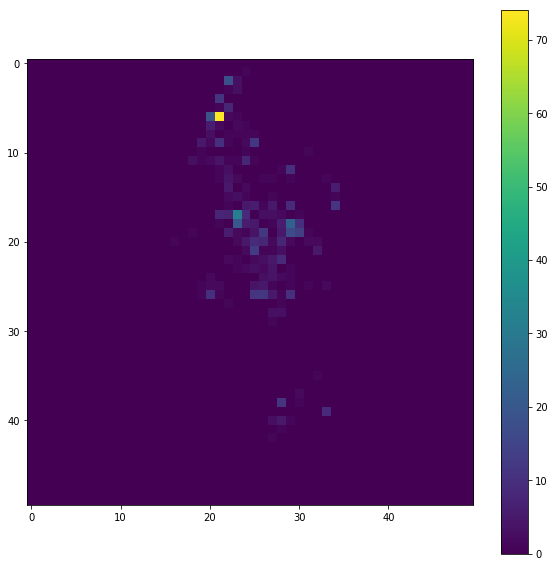

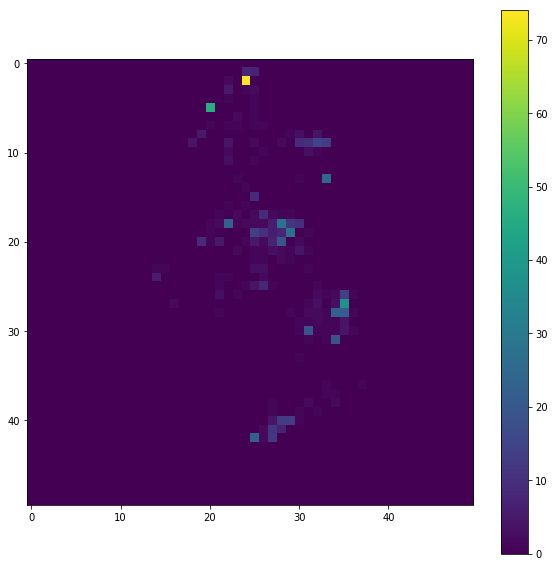

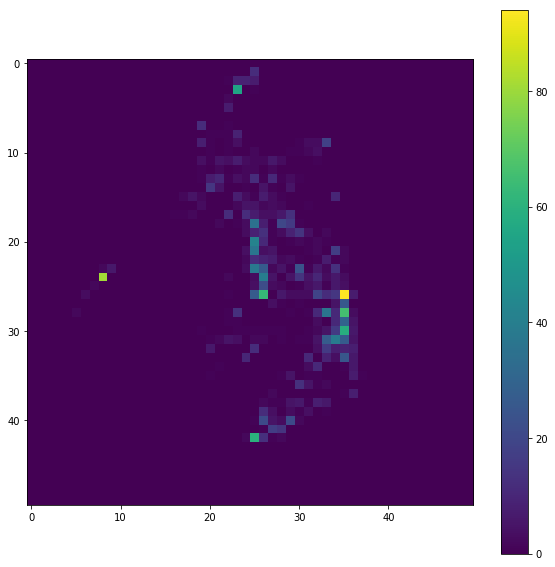

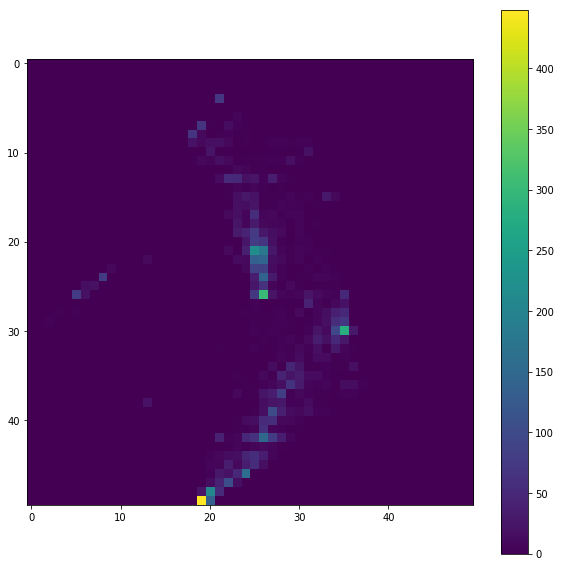

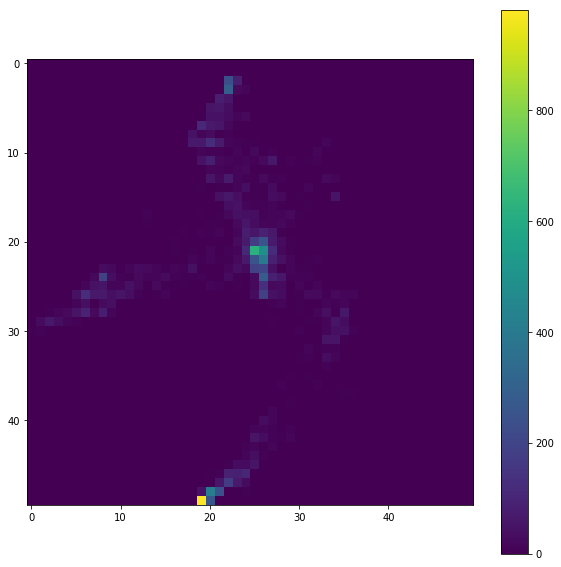

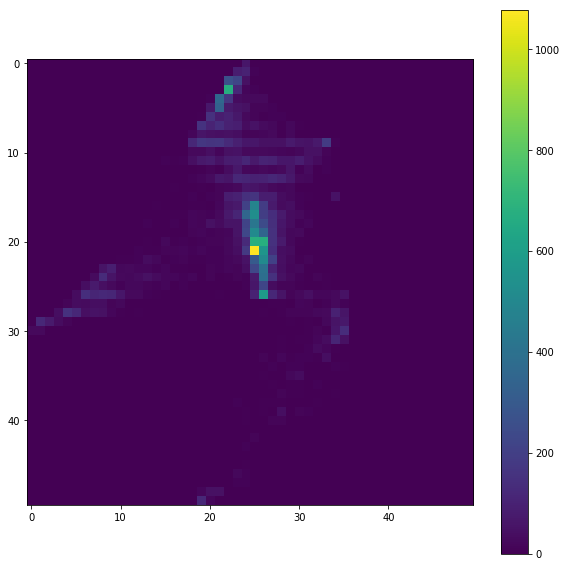

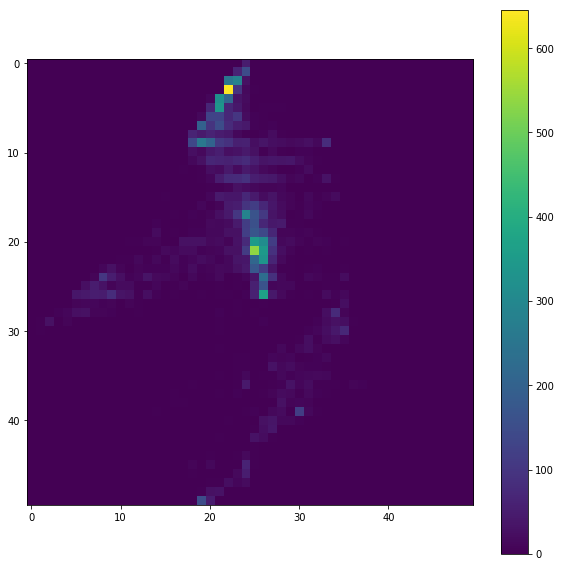

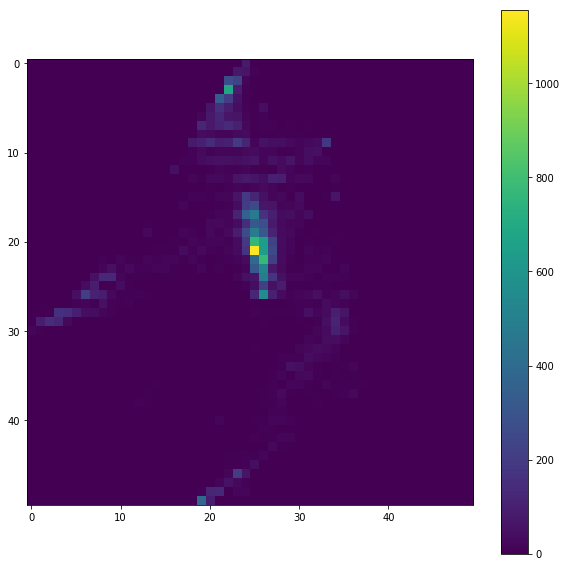

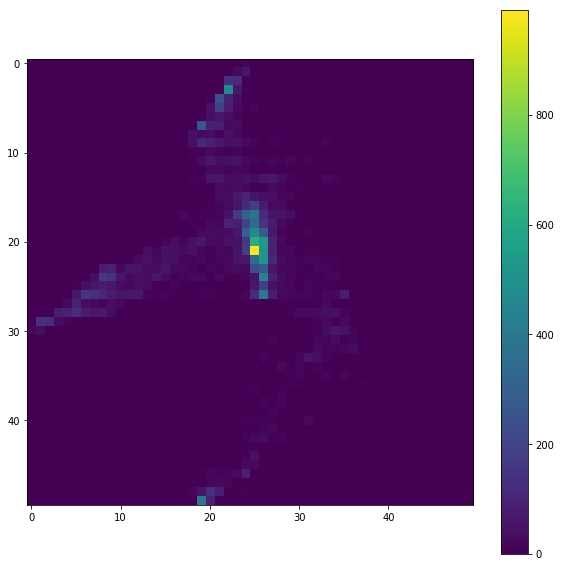

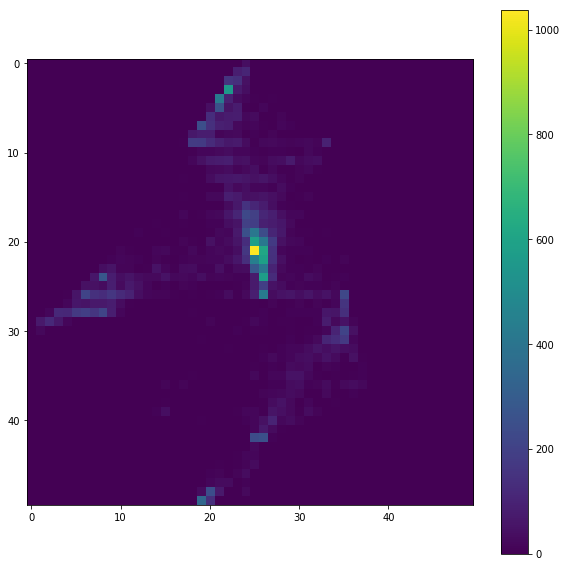

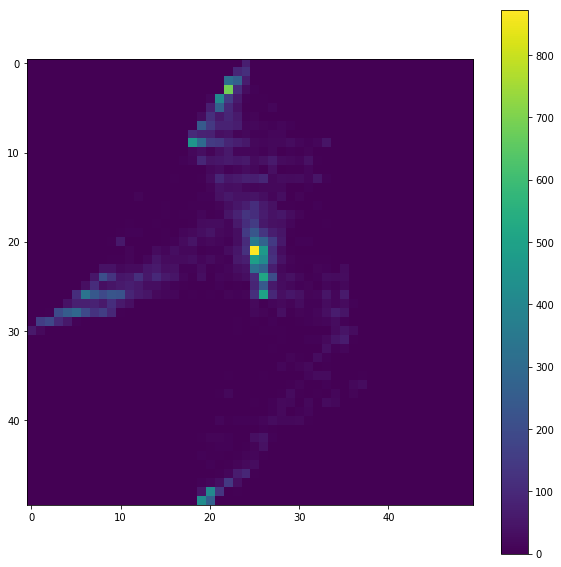

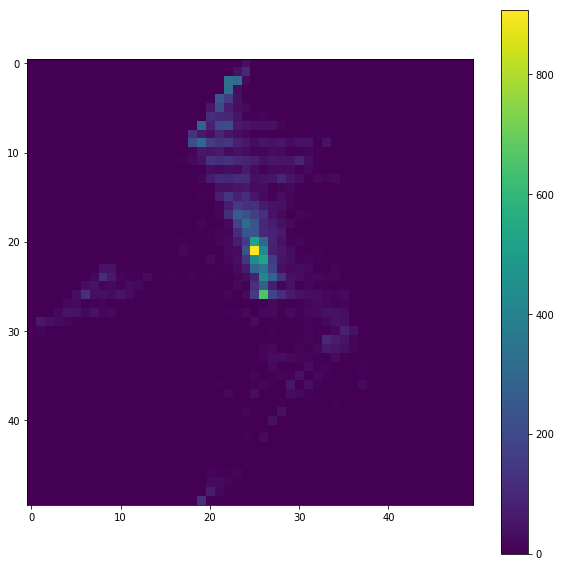

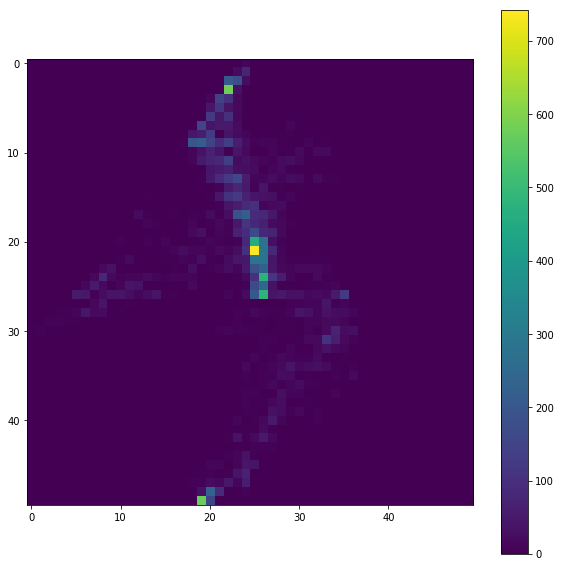

In [119]:
for i in range(0,19):
    plt.figure(figsize = (10,10))
    plt.imshow(mapper[(0, 5, 1, i, 0)])
    plt.colorbar()
    plt.show()

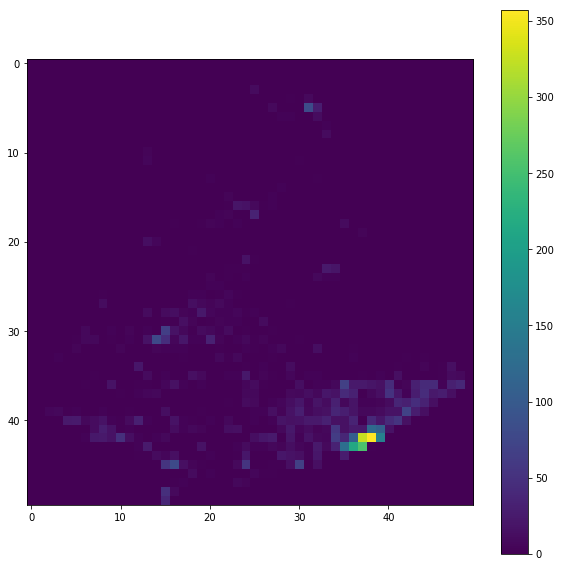

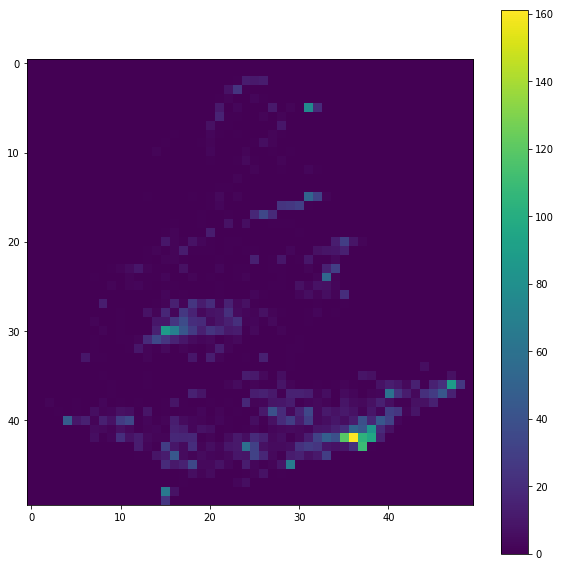

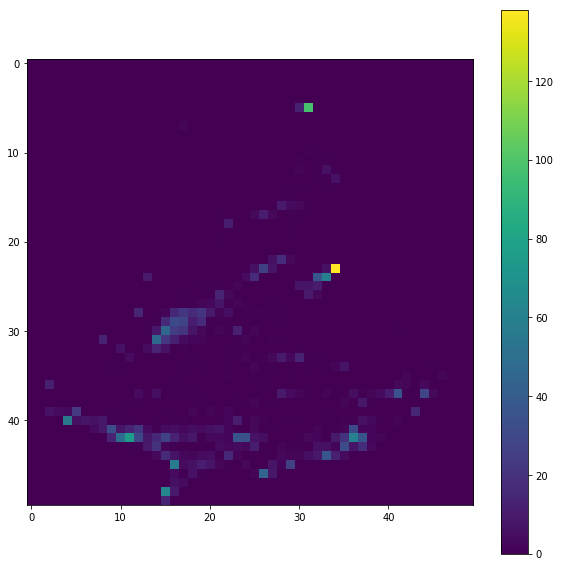

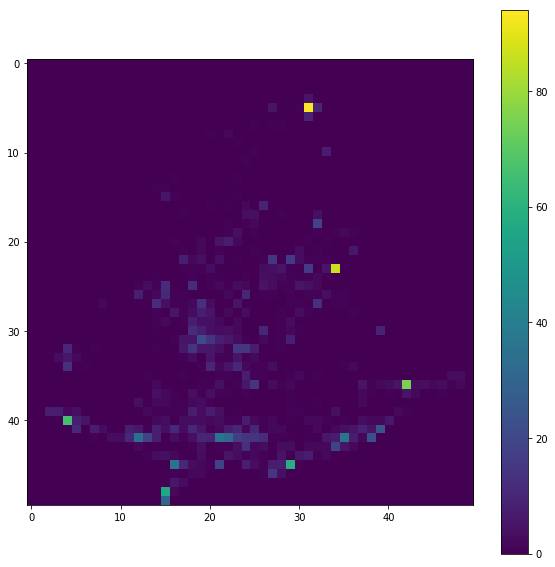

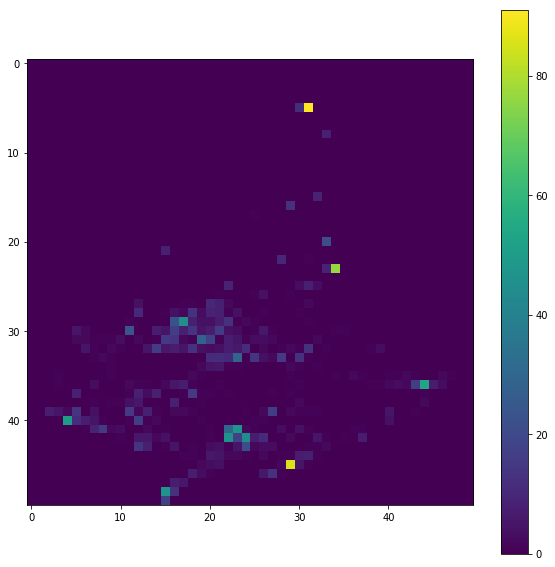

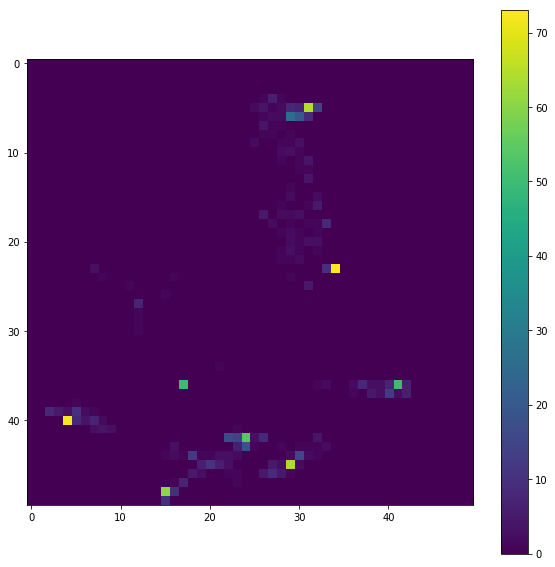

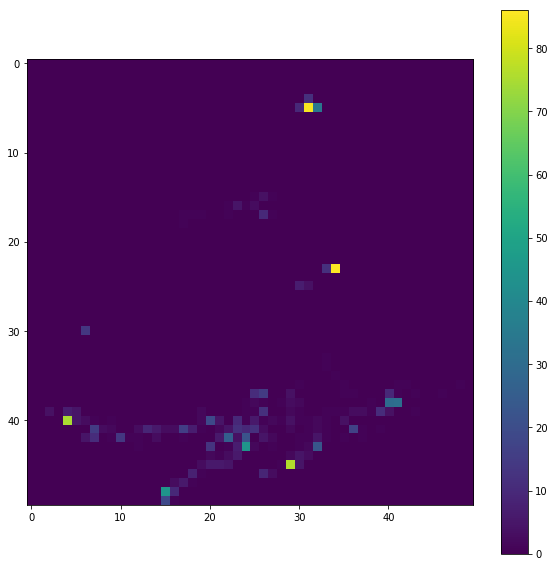

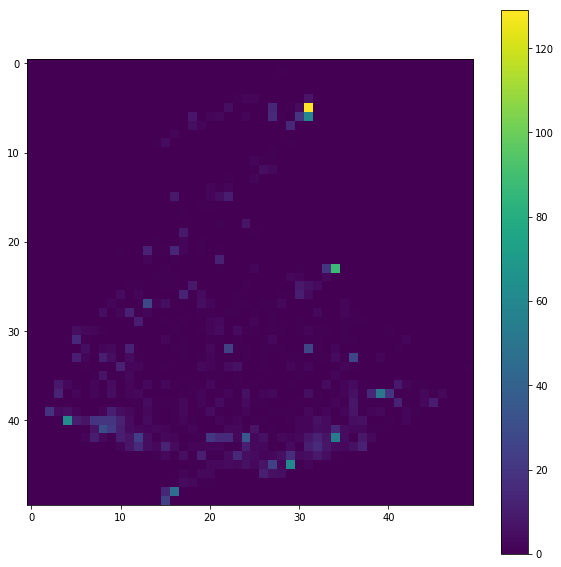

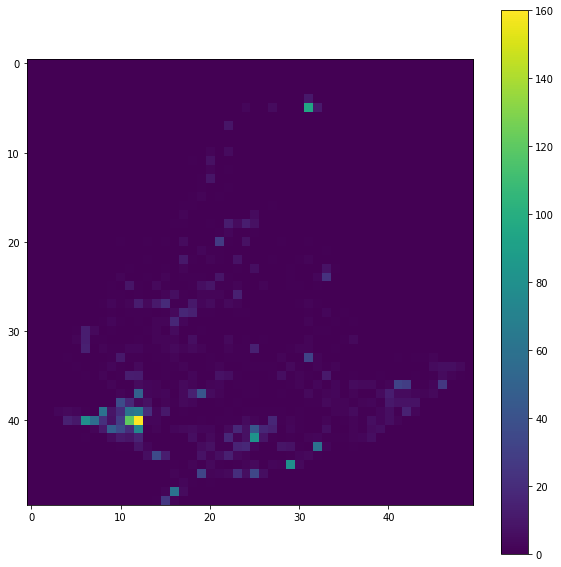

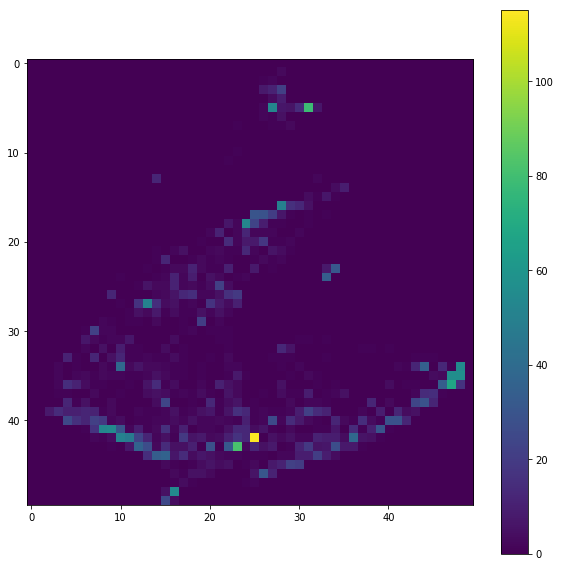

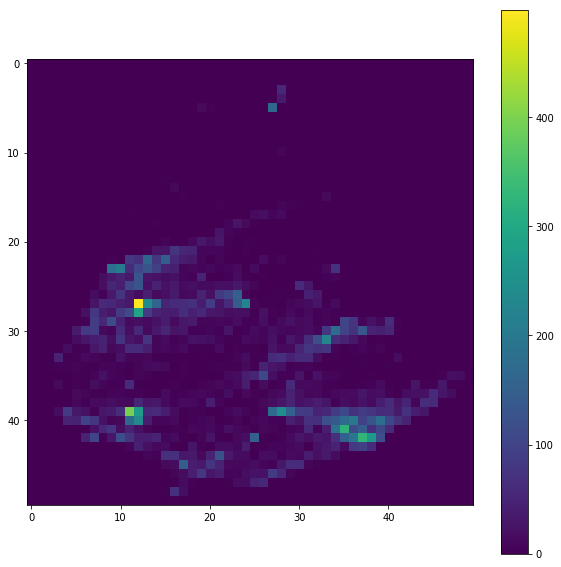

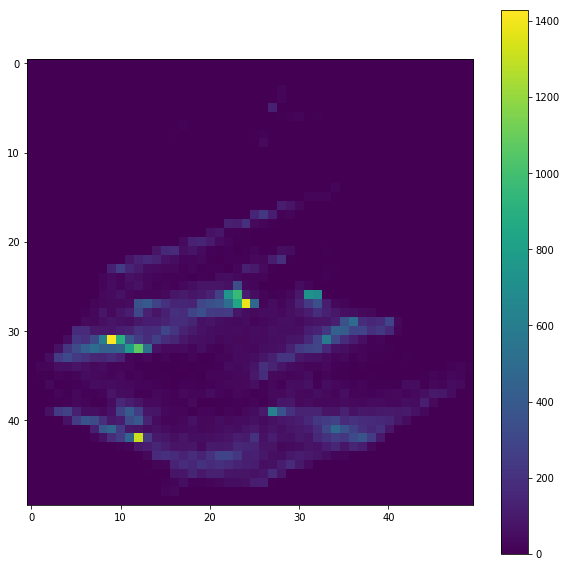

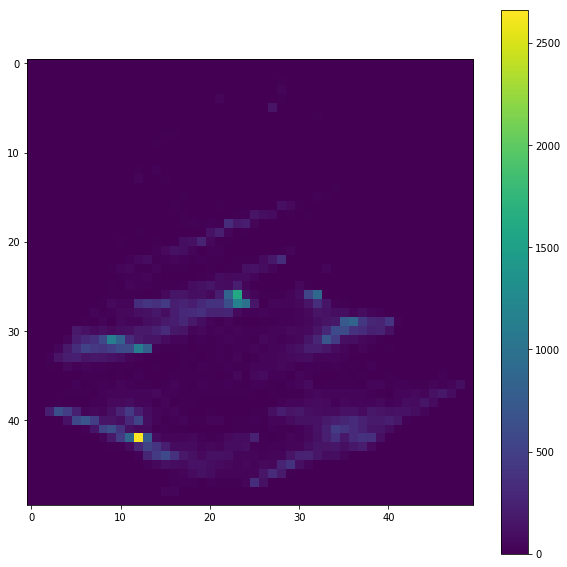

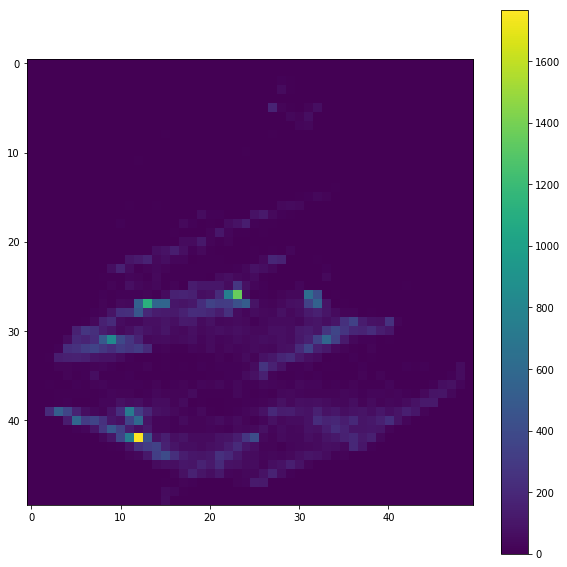

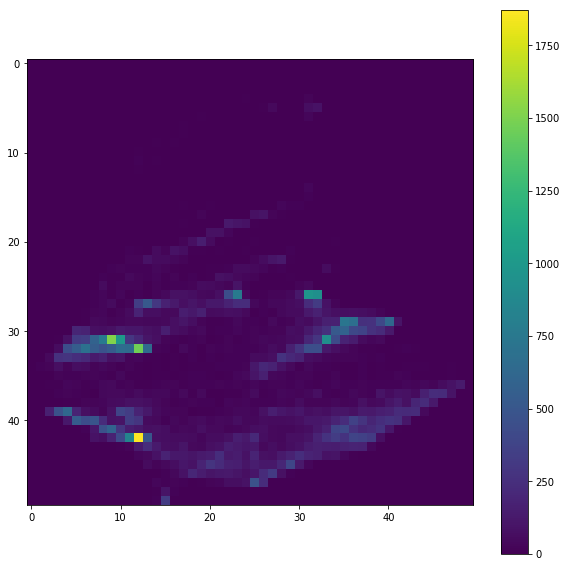

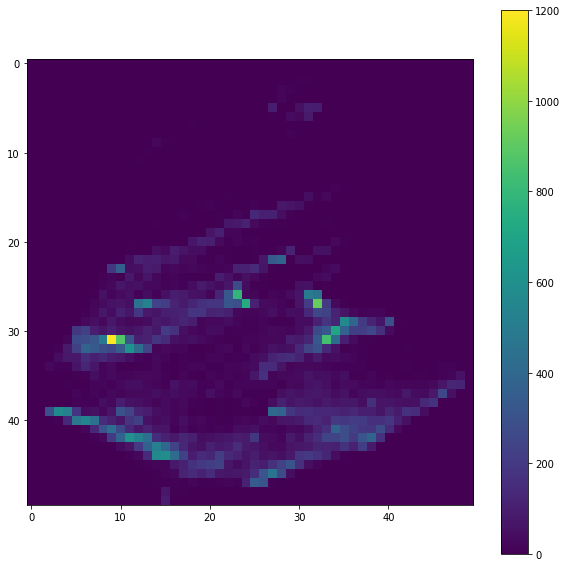

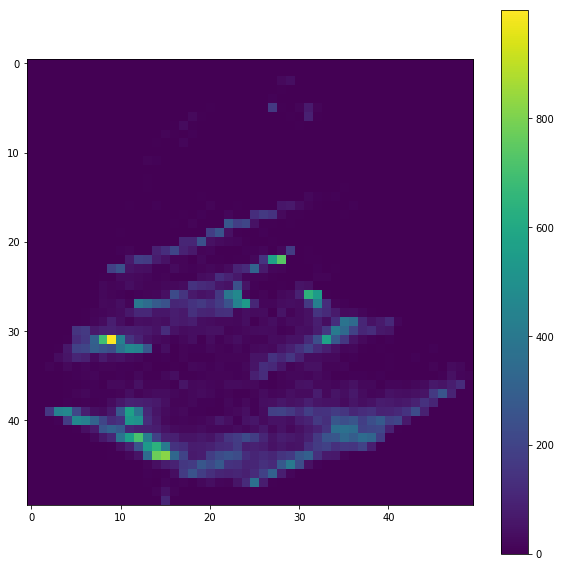

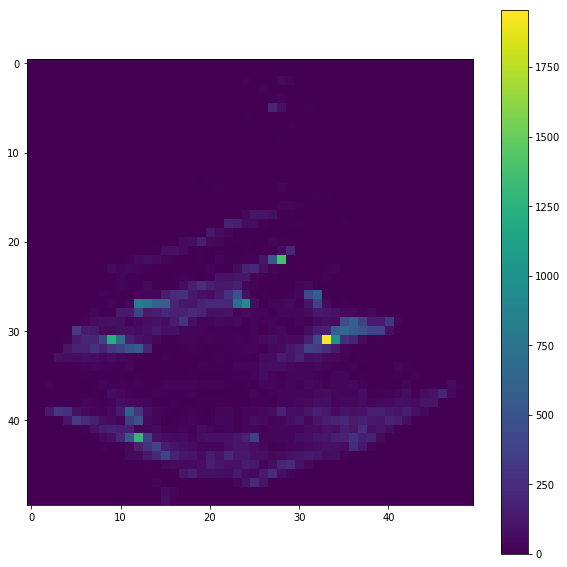

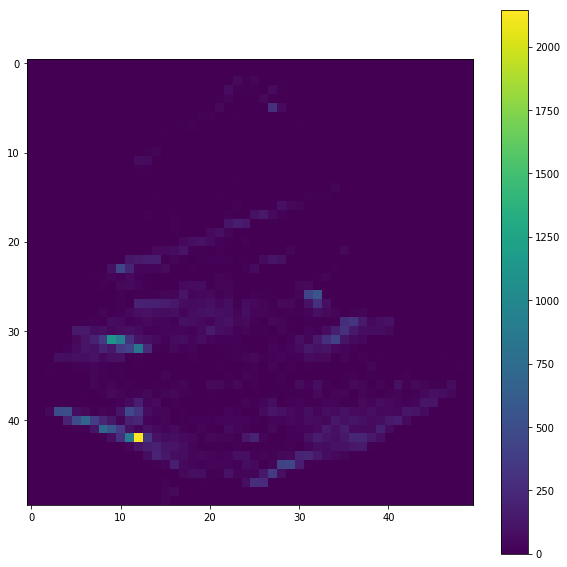

In [12]:
for i in range(0,19):
    plt.figure(figsize = (10,10))
    plt.imshow(mapper[(1, 5, 1, i, 0)])
    plt.colorbar()
    plt.show()

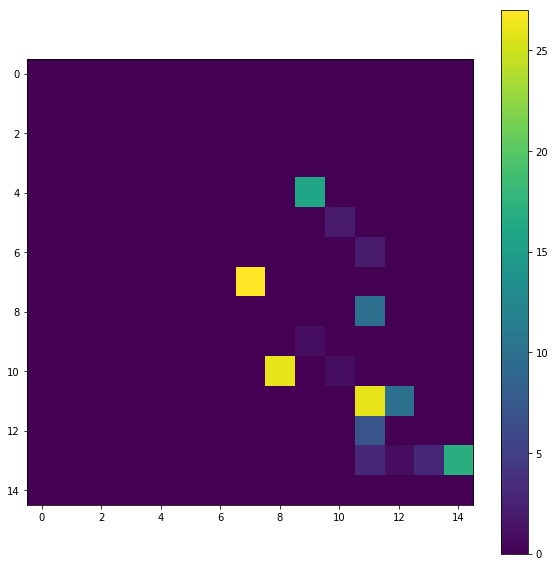

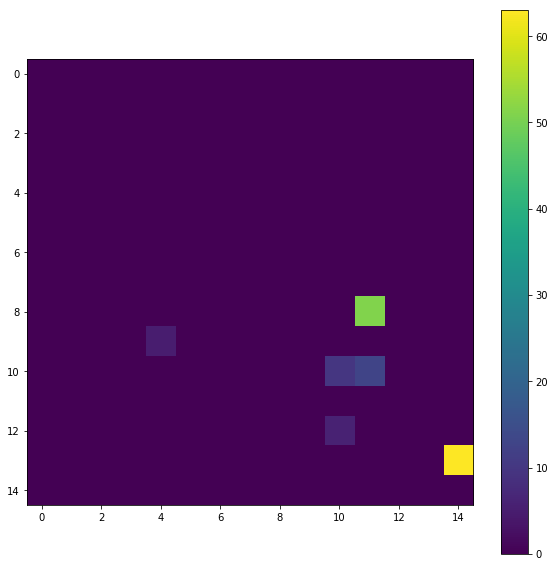

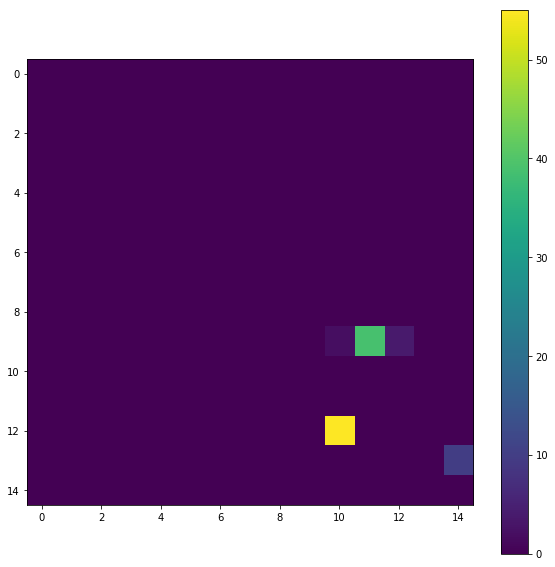

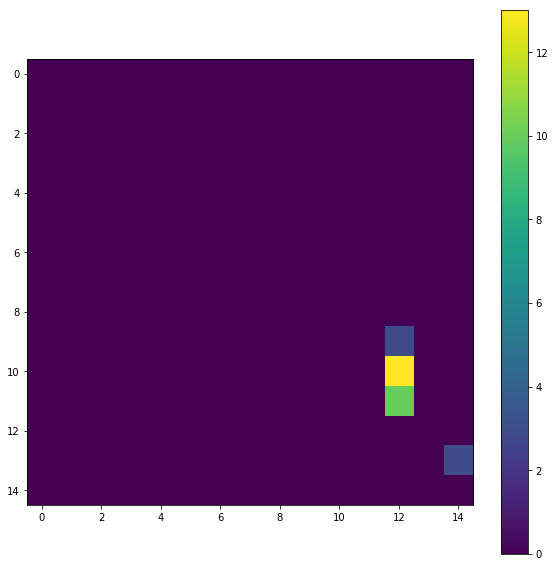

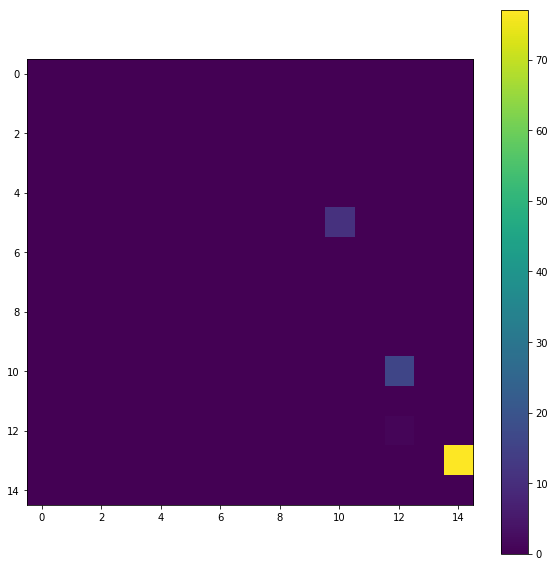

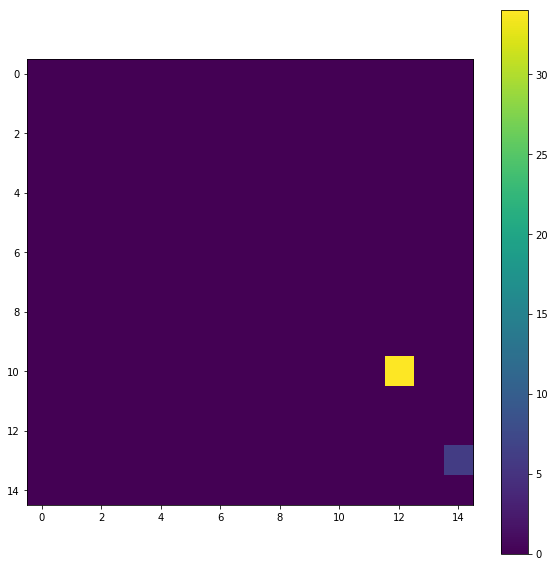

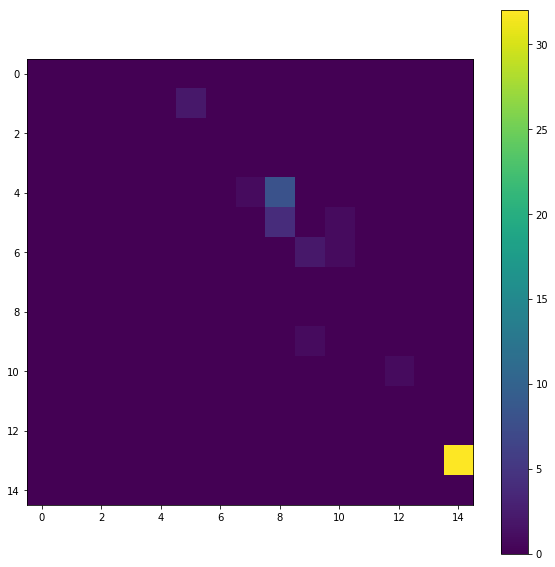

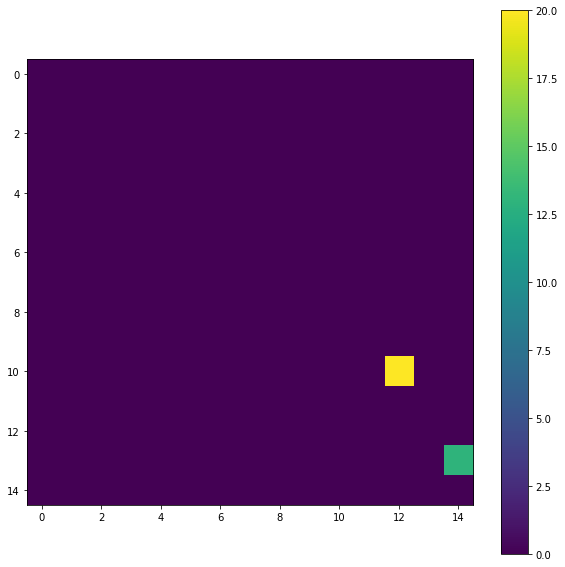

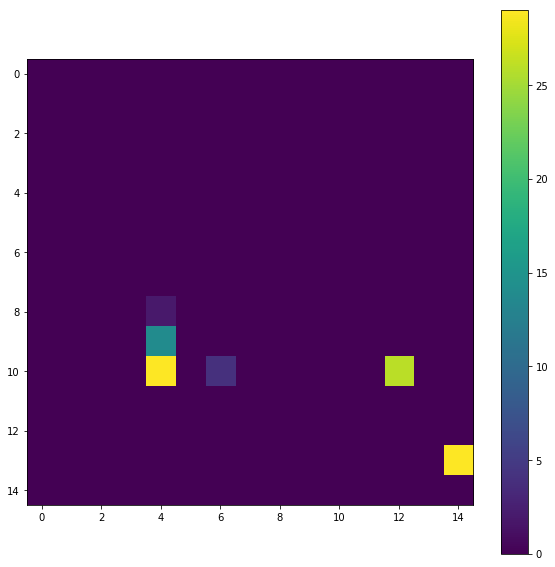

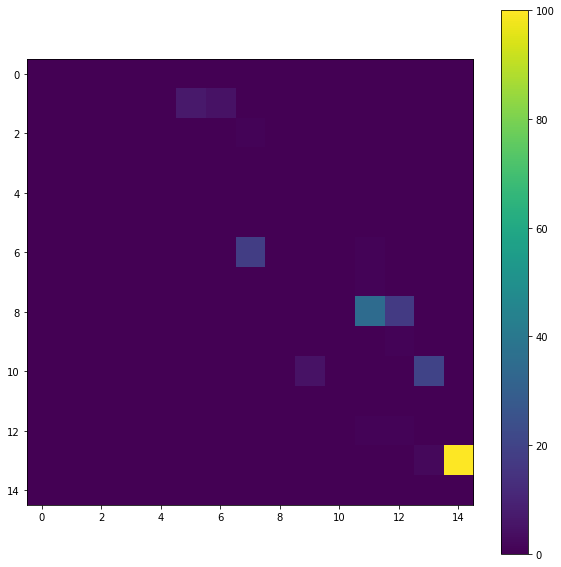

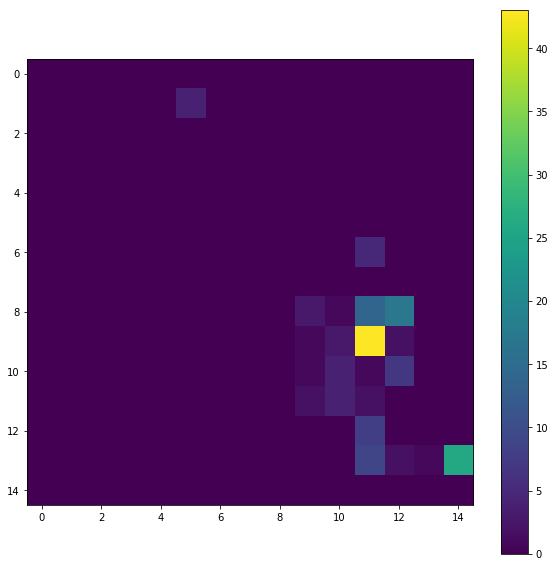

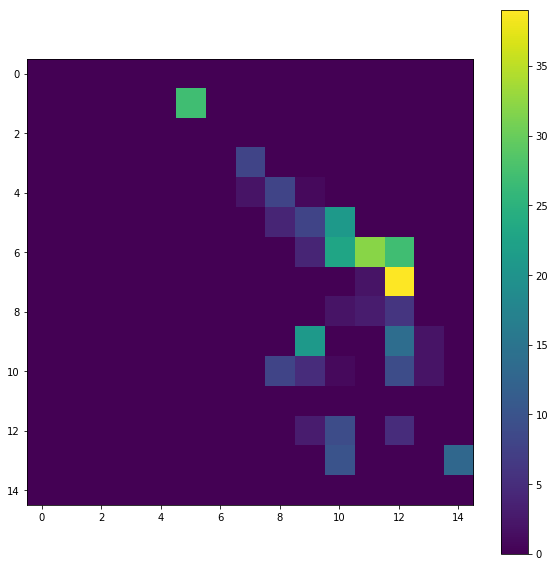

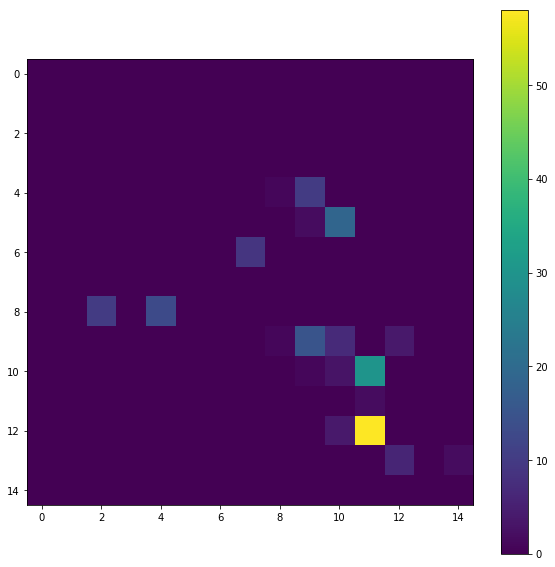

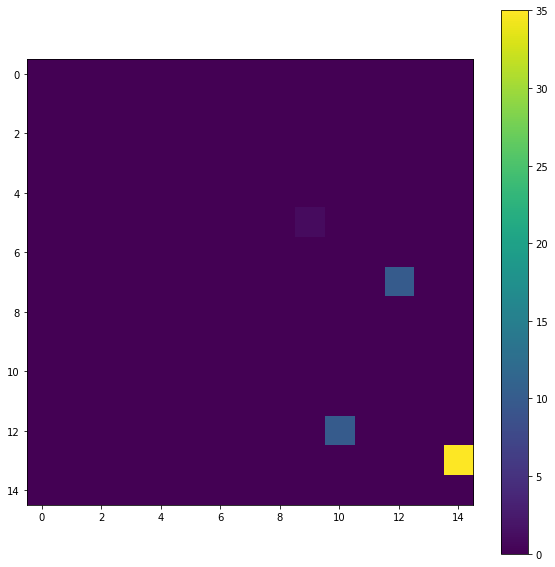

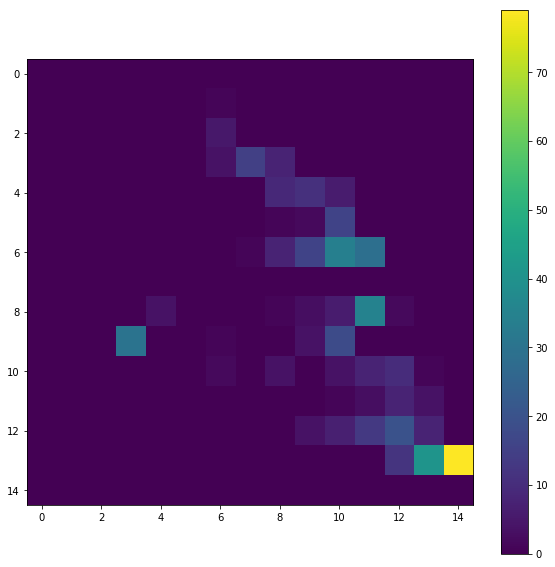

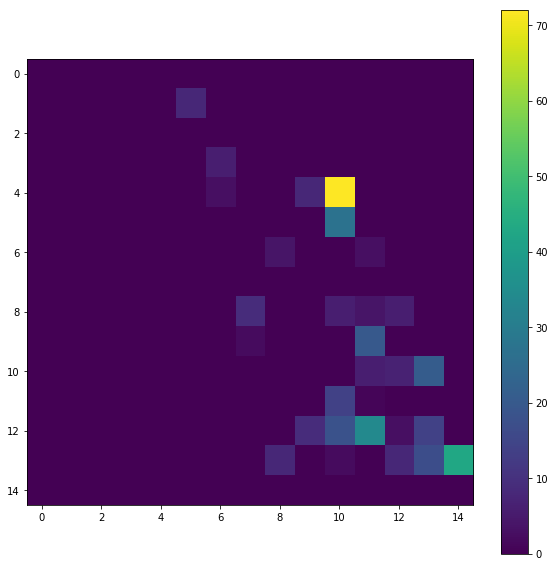

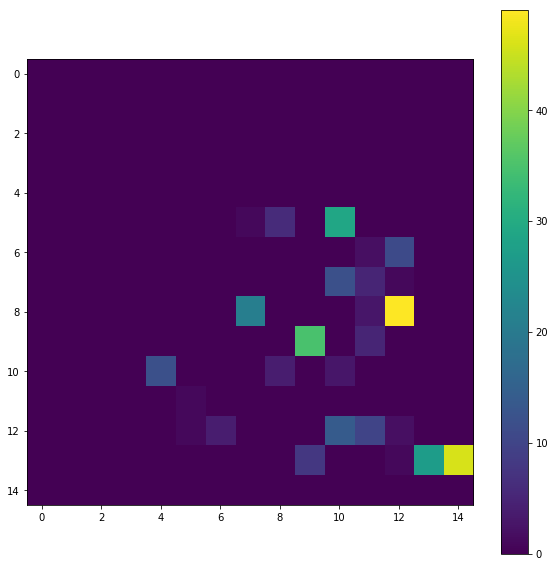

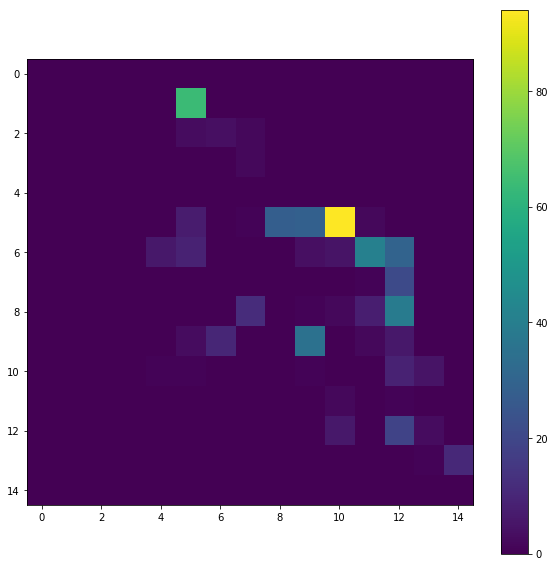

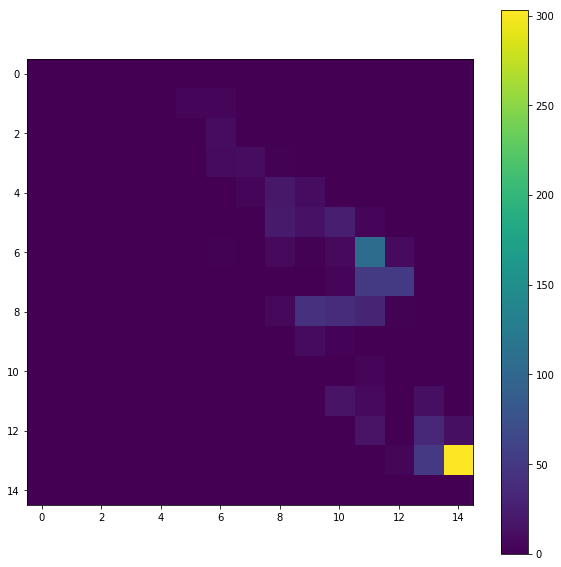

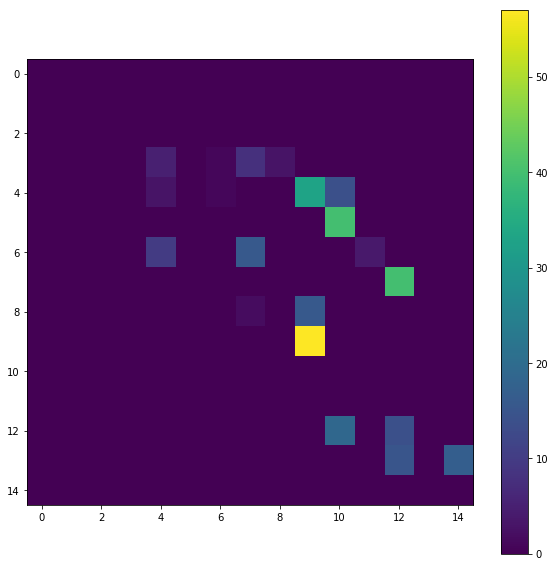

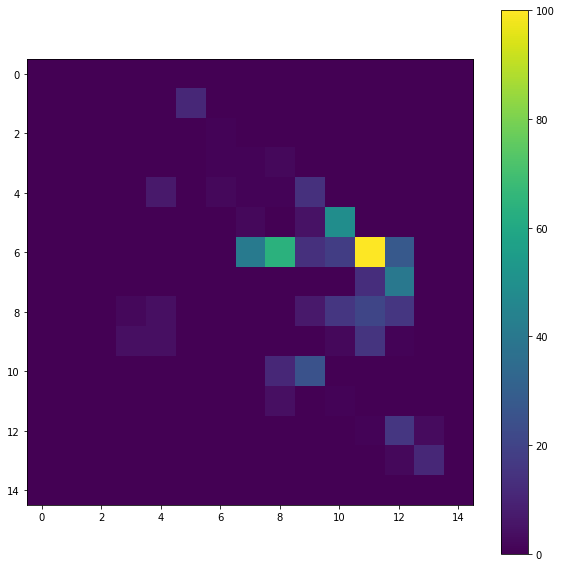

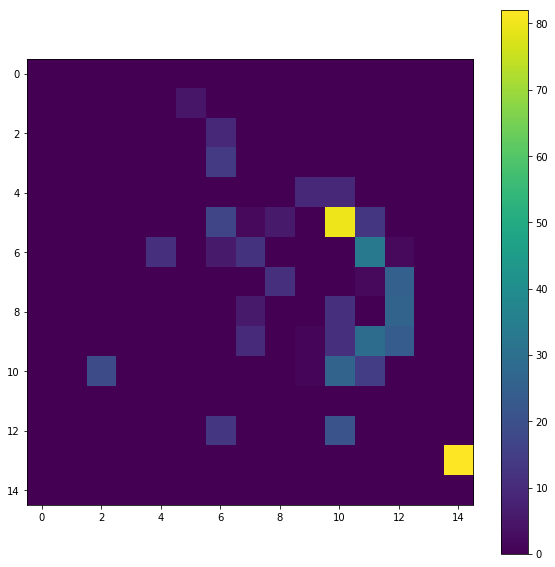

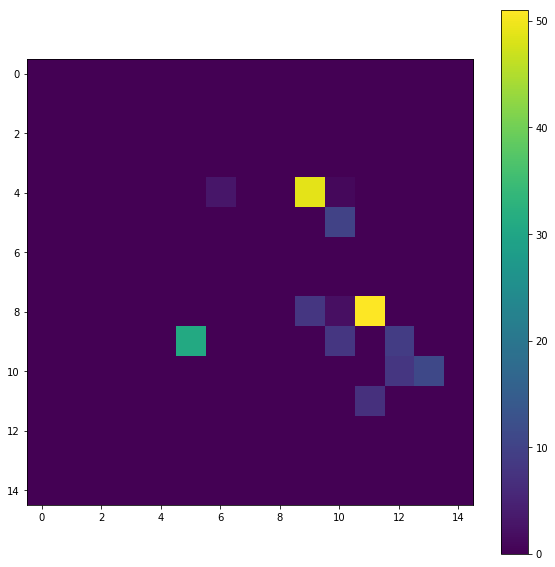

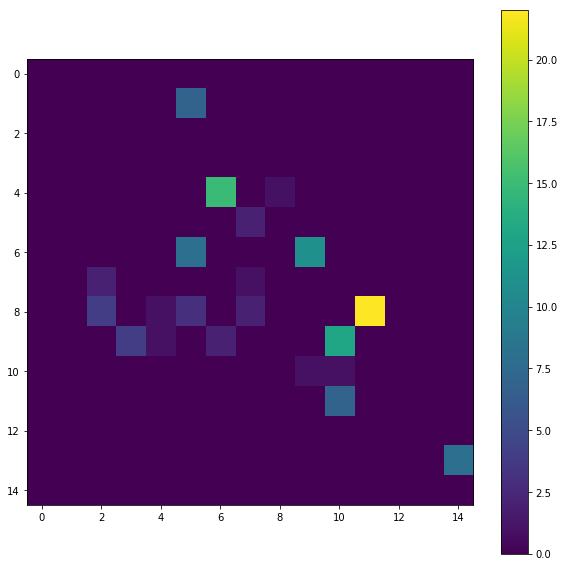

In [10]:
for i in range(0,24):
    plt.figure(figsize = (10,10))
    plt.imshow(mapper[(5, 5, 1, i, 0)])
    plt.colorbar()
    plt.show()

In [9]:
newMapper = {}
for key in mapper:
    ##(x['Level'], x['month'], x['day'], x['hour'], x['quarter'])
    if key[0]==0:
        val = newMapper.get(key[1:],[])
        val = [mapper[key]] + val
        newMapper[key[1:]] = val
    elif key[0]==1:
        val = newMapper.get(key[1:],[])
        val =  val +[mapper[key]]
        newMapper[key[1:]] = val
        
x = []
y = []
for key in newMapper:
    if len(newMapper[key])==2:
        flag=(newMapper[key][0] + newMapper[key][1])>0
        x.extend(newMapper[key][0][flag])
        y.extend(newMapper[key][1][flag])

del newMapper

In [50]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def lgbm(shuffle=False):
    kf = KFold(n_splits=5,shuffle=True)
    param = {
        'num_leaves':31,
        'num_iterations':100,
        'objective':'regression',
        'max_depth': 9,
        'learning_rate': 0.001,
        "lambda_l1": 0.1,
        "metric": 'rmse'
    }
    if shuffle:
        Y=np.random.permutation(np.array(y)).reshape((len(x),1))
    else:
        Y=np.array(y).reshape((len(x),1))
    X=np.array(x).reshape((len(x),1))
    
    oof=np.zeros(len(x))

    for fold_, (trnIdx,valIdx) in enumerate(kf.split(x)):
        print("fold %d"%fold_)
        num_round = 1000
        trnData = lgb.Dataset(X[trnIdx,:], label=Y[trnIdx,0])
        valData = lgb.Dataset(X[valIdx,:], label=Y[valIdx,0])
        bst = lgb.train(param, trnData, num_round, valid_sets=[trnData, valData],verbose_eval=False, early_stopping_rounds = 100)
        oof[valIdx]=bst.predict(X[valIdx])

    return np.sqrt(mean_squared_error(oof, y))

In [51]:
noShuffle=[]
for i in range(5):
    noShuffle.append(lgbm(shuffle=False))

withShuffle=[]
for i in range(100):
    withShuffle.append(lgbm(shuffle=True))

fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4
fold 0


/home/yuhanwg/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


fold 1
fold 2
fold 3
fold 4


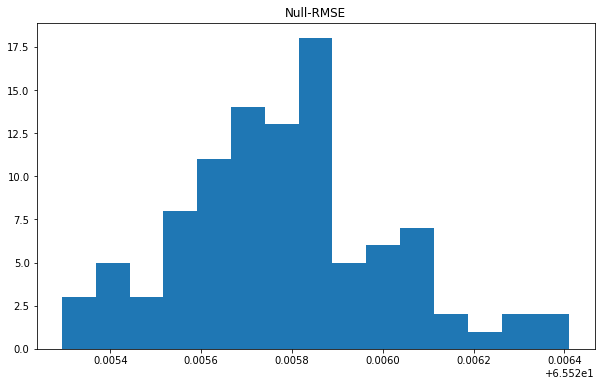

In [68]:
plt.figure(figsize=(10,6))
plt.hist(withShuffle, bins=15)
plt.title("Null-RMSE")
#plt.axvline(x=np.log(np.mean(noShuffle)))
plt.show()

In [92]:
from sklearn.utils import resample
Y = np.array(y)
X = np.array(x)
                        
coef=[]
for i in range(100):
    x_, y_ = resample(X,Y,n_samples=int(0.7 * X.shape[0]),replace=False)
    coef.append(np.corrcoef(x_,y_)[0,1])

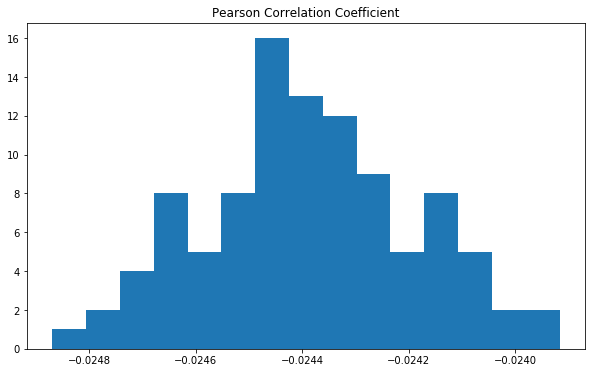

In [94]:
plt.figure(figsize=(10,6))
plt.hist(coef, bins=15)
plt.title("Pearson Correlation Coefficient")
plt.show()

In [95]:
print(np.mean(coef))
print(np.std(coef))

-0.024387603729687745
0.00019795730116409972


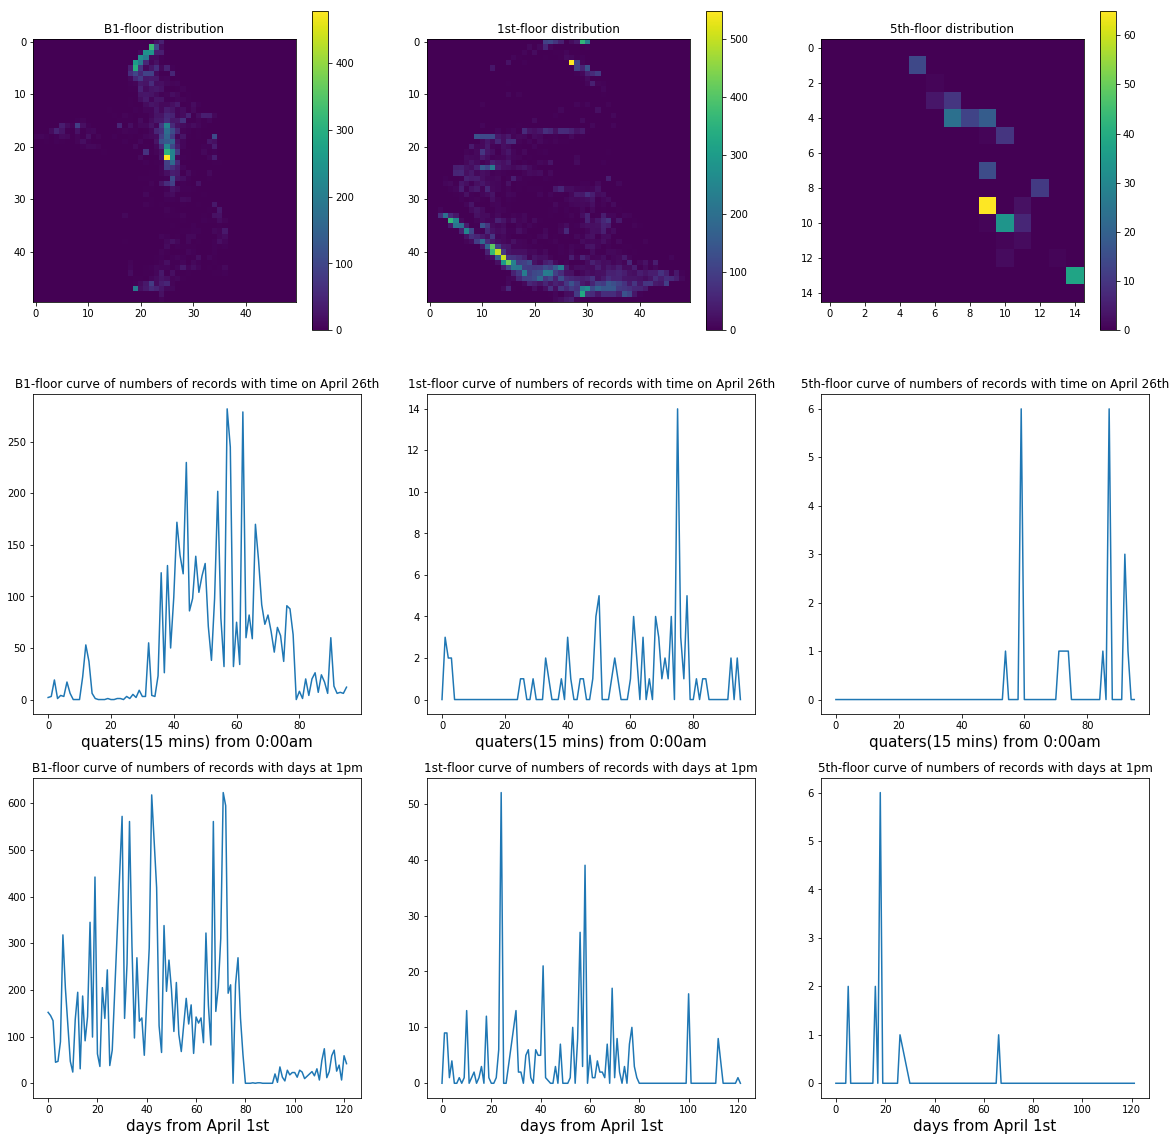

In [12]:
plt.figure(figsize = (20,20))

plt.subplot(3, 3, 1)
plt.title("B1-floor distribution")
plt.imshow(mapper[(0, 4, 26, 13, 0)])
plt.colorbar()

plt.subplot(3, 3, 2)
plt.title("1st-floor distribution")
plt.imshow(mapper[(1, 4, 26, 13, 0)])
plt.colorbar()

plt.subplot(3, 3, 3)
plt.title("5th-floor distribution")
plt.imshow(mapper[(5, 4, 26, 13, 0)])
plt.colorbar()

plt.subplot(3, 3, 4)
plt.title("B1-floor curve of numbers of records with time on April 26th")
plotF(day = (0, 4, 26, 12, 0),blockPos=(25,26))
plt.xlabel("quaters(15 mins) from 0:00am",size=15)

plt.subplot(3, 3, 5)
plt.title("1st-floor curve of numbers of records with time on April 26th")
plotF(day = (1, 4, 26, 12, 0),blockPos=(25,26))
plt.xlabel("quaters(15 mins) from 0:00am",size=15)

plt.subplot(3, 3, 6)
plt.title("5th-floor curve of numbers of records with time on April 26th")
plotF(day = (5, 4, 26, 12, 0),blockPos=(7,8))
plt.xlabel("quaters(15 mins) from 0:00am",size=15)

plt.subplot(3, 3, 7)
plt.title("B1-floor curve of numbers of records with days at 1pm")
plotF(hour = (0, 4, 26, 13, 0),blockPos=(25,26))
plt.xlabel("days from April 1st",size=15)

plt.subplot(3, 3, 8)
plt.title("1st-floor curve of numbers of records with days at 1pm")
plotF(hour = (1, 4, 26, 13, 0),blockPos=(25,26))
plt.xlabel("days from April 1st",size=15)

plt.subplot(3, 3, 9)
plt.title("5th-floor curve of numbers of records with days at 1pm")
plotF(hour = (5, 4, 26, 13, 0),blockPos=(7,7))
plt.xlabel("days from April 1st",size=15)

plt.show()

In [11]:
def plotF(**kwargs):
    """
    plot in one day: {'day':(Level,month,day,0,0), 'blockPos':(lng,lat)}
    plot in one clock: {'hour':(Level,0,0,hour,quater), 'blockPos':(lng,lat)}
    """
    if "day" in kwargs:
        vector = []
        for key in mapper:
            if key[:3] == kwargs['day'][:3]:
                vector.append((key[3:], mapper[key][kwargs['blockPos']]))
        vector = map(lambda x: (x[0][0]*4+x[0][1], x[1]), sorted(vector, key=lambda x:x[0]))
    elif 'hour' in kwargs:
        vector = []
        for key in mapper:
            if key[0] == kwargs['hour'][0] and key[3:]==kwargs['hour'][3:]:
                vector.append((key[1:3], mapper[key][kwargs['blockPos']]))
        vector = map(lambda x: ((dt.datetime(2017,x[0][0],x[0][1])-dt.datetime(2017,4,1)).days, x[1]), sorted(vector, key=lambda x:x[0]))
    else:
        print("False")
        return
    
    vector=np.array(list(vector))
    plt.plot(vector[:,0],vector[:,1])
    #plt.show()

In [148]:
aggs = df.groupby(['month','day']).agg({'count':'sum'}).reset_index()

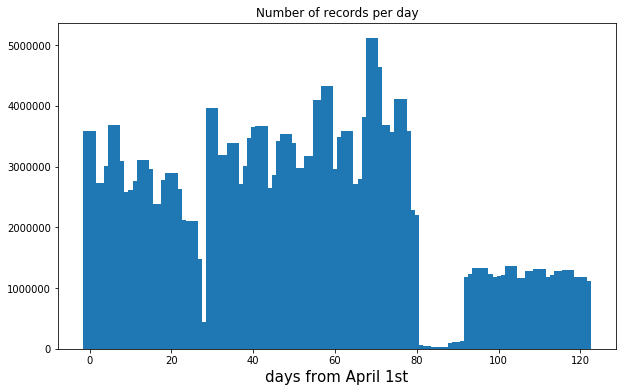

In [209]:
plt.figure(figsize=(10,6))
plt.title("Number of records per day")
plt.bar(aggs.days, aggs['count'],align='center',linewidth=0,width=3)
plt.xlabel("days from April 1st",size=15)
plt.show()

In [162]:
aggs.head()

,month,day,count,days
0,4,1,3594104,0
1,4,2,2521443,1
2,4,3,2670969,2
3,4,4,2725732,3
4,4,5,2704480,4


In [159]:
df['days'] = df.apply(lambda x:(pd.datetime(2017,x.month,x.day)-pd.datetime(2017,4,1)).days, axis=1)

(119,)

AttributeError: 'function' object has no attribute 'shape'